Insertar Dependencias


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, roc_curve, precision_recall_curve
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from pathlib import Path
from sklearn.pipeline import Pipeline



In [3]:
import sys
print("Python exe:", sys.executable)
print("Python ver:", sys.version)

# Actualiza pip e instala xgboost en ESTE kernel
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install xgboost

# Comprueba import
import xgboost
print("xgboost", xgboost.__version__)

from xgboost import XGBClassifier

Python exe: /Users/yaelmarquez/anaconda3/envs/tecmx/bin/python
Python ver: 3.11.7 (main, Dec 15 2023, 12:09:56) [Clang 14.0.6 ]
  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.0 MB/s  0:00:00 eta 0:00:01
xgboost 3.0.5


Unirlo con AWS

In [ ]:
##pip install "dvc[s3]"

##dvc --version
""" export AWS_ACCESS_KEY_ID="-"
export AWS_SECRET_ACCESS_KEY="-"
export AWS_DEFAULT_REGION="us-east-1" """


In [16]:
BASE_DATA_DIR = Path("/Users/yaelmarquez/Documents/VS_CODE/MNAV  - Maestría en Inteligencia Artificial Aplicada/Operaciones de aprendizaje automático/MLOps/proyect_team42/data")

csv_path = BASE_DATA_DIR / "insurance_company_original.csv"
df = pd.read_csv(csv_path)

In [ ]:
df.columns = df.columns.str.strip() 
df = df.rename(columns={'0.45': 'CARAVAN'})
TARGET = 'CARAVAN'

print("TARGET:", TARGET)
print("Positivos (%):", df[TARGET].mean()*100)

TARGET: CARAVAN
Positivos (%): 5.978354234667583


Separación X / y // split estratificado

In [29]:
RANDOM_STATE = 42

X = df.drop(columns=[TARGET])
# objetivo binario 0/1
y = df[TARGET].astype(int)  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Positivos en train:", y_train.mean().round(4), " / test:", y_test.mean().round(4))


Train: (4656, 85)  Test: (1165, 85)
Positivos en train: 0.0597  / test: 0.0601


Validación Cruzada & Pipeline con Regresión Logísitca


In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipe_lr = Pipeline([
    #Escalar variables numéricas
    ("scaler", StandardScaler()),  
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))  # paso 2: modelo
])

param_lr = {
    "clf__C": [0.1, 0.5, 1.0, 2.0, 5.0],  
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

gs_lr = GridSearchCV(pipe_lr, param_lr, cv=cv, scoring="average_precision", n_jobs=-1, verbose=0)
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 0.5, 1.0, 2.0, 5.0],
                         'clf__penalty': ['l2'], 'clf__solver': ['lbfgs']},
             scoring='average_precision')

In [31]:
best_lr = gs_lr.best_estimator_
proba_lr = best_lr.predict_proba(X_test)[:,1]
pred_lr = (proba_lr >= 0.5).astype(int)

print("LR best params:", gs_lr.best_params_)
print("LR | ROC-AUC:", roc_auc_score(y_test, proba_lr))
print("LR | PR-AUC :", average_precision_score(y_test, proba_lr))
print(classification_report(y_test, pred_lr, digits=4))

LR best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
LR | ROC-AUC: 0.7518199608610567
LR | PR-AUC : 0.17241912793826358
              precision    recall  f1-score   support

           0     0.9720    0.6986    0.8130      1095
           1     0.1270    0.6857    0.2143        70

    accuracy                         0.6979      1165
   macro avg     0.5495    0.6922    0.5136      1165
weighted avg     0.9213    0.6979    0.7770      1165



LR best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
LR | ROC-AUC: 0.7518199608610567
LR | PR-AUC: 0.17241912793826358
              precision    recall  f1-score   support

           0     0.9720    0.6986    0.8130      1095
           1     0.1270    0.6857    0.2143        70

    accuracy                         0.6979      1165
   macro avg     0.5495    0.6922    0.5136      1165
weighted avg     0.9213    0.6979    0.7770      1165



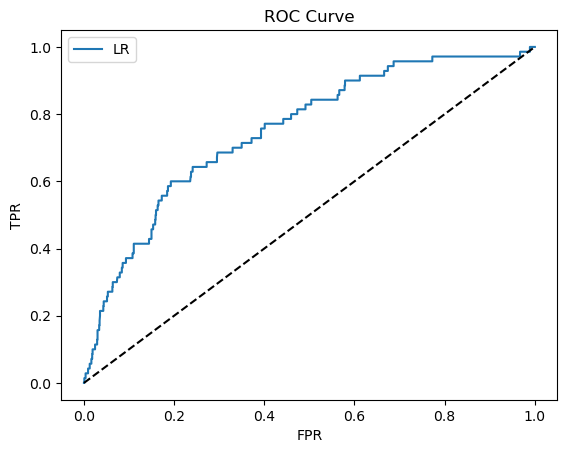

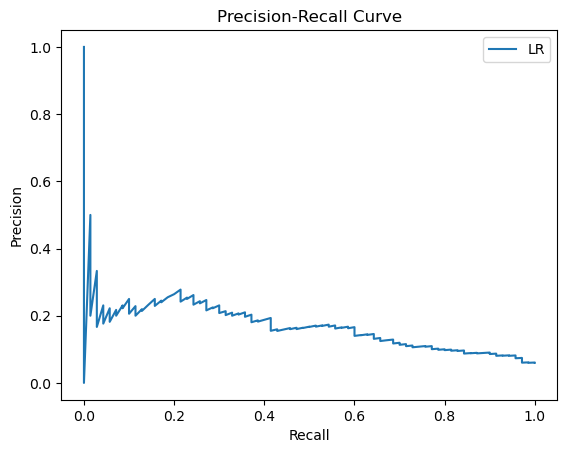

In [32]:
best_lr = gs_lr.best_estimator_
proba_lr = best_lr.predict_proba(X_test)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

print("LR best params:", gs_lr.best_params_)
print("LR | ROC-AUC:", roc_auc_score(y_test, proba_lr))
print("LR | PR-AUC:", average_precision_score(y_test, proba_lr))
print(classification_report(y_test, pred_lr, digits=4))

# --- Curva ROC ---
fpr, tpr, _ = roc_curve(y_test, proba_lr)
plt.plot(fpr, tpr, label="LR")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- Curva Precision-Recall ---
prec, rec, _ = precision_recall_curve(y_test, proba_lr)
plt.plot(rec, prec, label="LR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

Usando Random Forest

In [33]:
pipe_rf = Pipeline(steps=[
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"))
])

param_grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 8, 12, 16],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
}

gs_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring="average_precision", cv=cv, n_jobs=-1)
gs_rf.fit(X_train, y_train)

print("Best RF params:", gs_rf.best_params_)
print("Best CV PR-AUC:", gs_rf.best_score_)


Best RF params: {'clf__max_depth': 8, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}
Best CV PR-AUC: 0.1656992354882857


Best RF params: {'clf__max_depth': 8, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}
RF | ROC-AUC: 0.7821004566210046
RF | PR-AUC : 0.2044667867225996
              precision    recall  f1-score   support

           0     0.9607    0.8941    0.9262      1095
           1     0.2055    0.4286    0.2778        70

    accuracy                         0.8661      1165
   macro avg     0.5831    0.6613    0.6020      1165
weighted avg     0.9154    0.8661    0.8872      1165



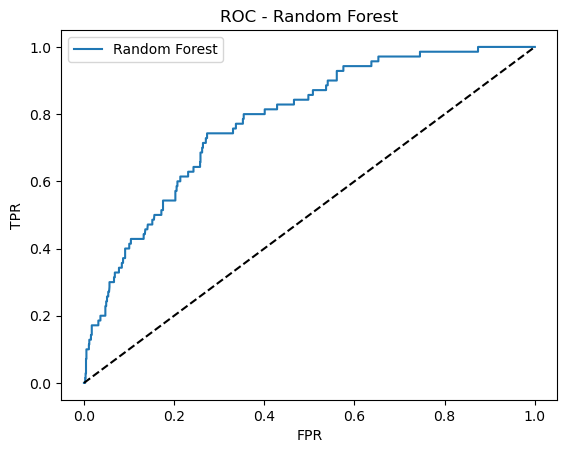

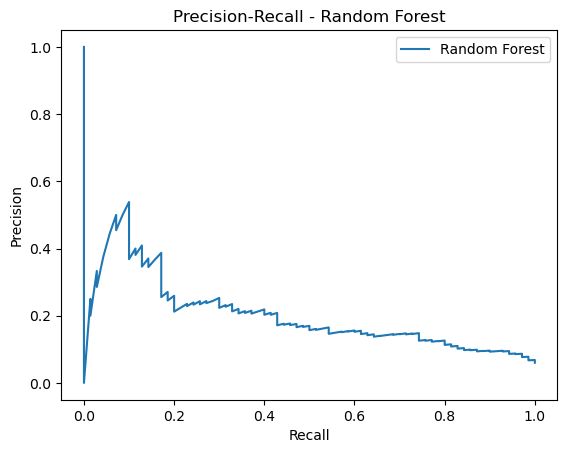

In [35]:
best_rf = gs_rf.best_estimator_
# Probabilidades y predicción con umbral 0.5 (puedes cambiar el umbral)
proba_rf = best_rf.predict_proba(X_test)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

# Métricas
print("Best RF params:", gs_rf.best_params_)
print("RF | ROC-AUC:", roc_auc_score(y_test, proba_rf))
print("RF | PR-AUC :", average_precision_score(y_test, proba_rf))
print(classification_report(y_test, pred_rf, digits=4))

# ----- Curva ROC -----
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Random Forest")
plt.legend()
plt.show()

# ----- Curva Precision-Recall -----
prec_rf, rec_rf, _ = precision_recall_curve(y_test, proba_rf)
plt.plot(rec_rf, prec_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall - Random Forest")
plt.legend()
plt.show()

XG Boost

In [36]:
xgb = XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),  # balancear clases
    eval_metric="aucpr",
    random_state=42
)

param_xgb = {
    "n_estimators": [200, 400],
    "max_depth": [3, 5, 8],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0]
}

gs_xgb = GridSearchCV(xgb, param_xgb, cv=5, scoring="average_precision", n_jobs=-1)
gs_xgb.fit(X_train, y_train)

print("Best XGB params:", gs_xgb.best_params_)
print("Best CV PR-AUC:", gs_xgb.best_score_)

Best XGB params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'subsample': 1.0}
Best CV PR-AUC: 0.17088060416884585
